# Momentum-Enhanced Hierarchical Risk Parity (HRP) with Cryptocurrencies

By: Cordell L. Tanny, CFA, FRM, FDP

Founder, Vault42 AI

June 5, 2025

This notebook and all code are the intellectual property of Vault42 AI and cannot be reproduced or retransmitted in any way without expressed written permission. All rights reserved.



---



This notebook builds a crypto portfolio using Hierarchical Risk Parity (HRP) combined with a 6-month momentum filter.

We will:
- Fetch the top 50 cryptocurrencies by market cap
- Download and clean daily pricing data
- Convert to monthly returns
- Filter assets with positive 6-month momentum
- Run HRP optimization (or equal weight fallback)
- Hold for 6 months, then repeat
- Compare performance to BTC and Equal Weight

In [ ]:
!pip install riskfolio-lib --quiet
import riskfolio as rp
import numpy as np
import pandas as pd
import warnings
from google.colab import userdata
import os
import requests
from datetime import datetime
from tqdm.notebook import tqdm

warnings.filterwarnings("ignore")
pd.options.display.float_format = '{:.4%}'.format

# We are using Financial Modeling Prep to download cryptocurrency data.
# You can register for a free account and get an API key.
# Feel free to adapt the notebook to download the data from other providers.

FMP_API_KEY = userdata.get('FMP')

### Step 1: Get Top Cryptocurrencies by Market Cap

- Uses the FMP API to fetch the top 50 coins.
- This defines the investment universe.


In [ ]:
def get_top_cryptos(limit=50):
    """
    Fetch top cryptocurrencies by market cap using FMP /quotes/crypto endpoint.
    Returns a list of top symbols.
    """
    url = f"https://financialmodelingprep.com/api/v3/quotes/crypto?apikey={FMP_API_KEY}"
    response = requests.get(url)
    data = response.json()

    df = pd.DataFrame(data)
    df = df[df['marketCap'].notna()].sort_values(by='marketCap', ascending=False)
    top_symbols = df['symbol'].head(limit).tolist()
    return top_symbols

### Step 2: Download Historical Price Data

- Fetches daily close prices using the FMP API.
- Coins with less than 5 years of history are excluded.


In [ ]:
def download_crypto_prices(symbol):
    """
    Download historical daily close prices for a crypto symbol using FMP.
    Returns a DataFrame with date and close columns.
    """
    url = f"https://financialmodelingprep.com/api/v3/historical-price-full/{symbol}?serietype=line&apikey={FMP_API_KEY}"
    response = requests.get(url)

    if response.status_code != 200:
        print(f"Failed to get data for {symbol}")
        return None

    data = response.json()
    if 'historical' not in data:
        return None

    df = pd.DataFrame(data['historical'])
    df['date'] = pd.to_datetime(df['date'])
    df.set_index('date', inplace=True)
    df = df[['close']].sort_index()
    return df


def load_and_filter_crypto_data(min_days=1825):
    """
    Fetch top 50 cryptos, download daily prices, filter for at least `min_days` of data.
    Returns a dict of {symbol: DataFrame}, all with sufficient history.
    """
    top_symbols = get_top_cryptos()
    print(f"Found {len(top_symbols)} top symbols.")

    valid_data = {}
    for symbol in tqdm(top_symbols, desc="Downloading prices"):
        df = download_crypto_prices(symbol)
        if df is not None and len(df) >= min_days:
            valid_data[symbol] = df

    print(f"Retained {len(valid_data)} symbols with ≥{min_days} days of data.")
    return valid_data


def combine_close_prices(data_dict):
    """
    Combine individual crypto DataFrames into a single wide-format DataFrame of close prices.
    """
    df_all = pd.DataFrame()
    for symbol, df in data_dict.items():
        df_all[symbol] = df['close']
    return df_all


In [ ]:
crypto_data_dict = load_and_filter_crypto_data()
df_daily_prices = combine_close_prices(crypto_data_dict)

# Save to csv
df_daily_prices.to_csv('crypto_daily_prices.csv')


Found 50 top symbols.


✅ Retained 26 symbols with ≥1825 days of data.


### Step 3: Convert Daily Prices to Monthly Returns

- Resamples price data to end-of-month frequency.
- Calculates monthly percent returns.


In [ ]:
# Step 1: Resample to month-end close
df_monthly_prices = df_daily_prices.resample("M").last()

# Step 2: Compute percentage returns
df_monthly_returns = df_monthly_prices.pct_change().dropna()

# Optional: Use log returns instead
# df_monthly_returns = np.log(df_monthly_prices / df_monthly_prices.shift(1)).dropna()

# Step 3: Drop columns with any missing values (optional, for clean HRP input)
df_monthly_returns = df_monthly_returns.dropna(axis=1)

stablecoins = ['USDCUSD', 'USDTUSD', 'TUSDUSD', 'DAIUSD', 'USTUSD']
df_monthly_returns = df_monthly_returns.drop(columns=[c for c in df_monthly_returns.columns if c in stablecoins])

# Print shape and preview
print(f"Monthly return shape: {df_monthly_returns.shape}")
df_monthly_returns.tail()


Monthly return shape: (61, 21)


,BTCUSD,ETHUSD,XRPUSD,BNBUSD,SOLUSD,DOGEUSD,ADAUSD,TRXUSD,WBTCUSD,LINKUSD,...,BCHUSD,XMRUSD,LTCUSD,BTCBUSD,WETHUSD,HBARUSD,OKBUSD,GTUSD,ETCUSD,CROUSD
date,,,,,,,,,,,,,,,,,,,,,
2025-01-31,9.7018%,-0.9107%,45.9770%,-3.3683%,22.7148%,4.2808%,11.7263%,-0.1457%,9.1095%,25.9463%,...,-2.1230%,23.5967%,24.2166%,9.4187%,-1.0856%,14.2442%,7.6724%,43.4842%,7.3718%,-7.6102%
2025-02-28,-17.6870%,-32.2313%,-29.3381%,-13.2753%,-36.0882%,-38.6608%,-32.8770%,-7.9962%,-17.6107%,-41.1465%,...,-25.5806%,-8.6514%,-0.0234%,-15.2987%,-32.4904%,-30.3894%,-14.7149%,-12.5338%,-27.0522%,-43.0331%
2025-03-31,-2.0919%,-18.5270%,-2.5830%,2.9996%,-15.9025%,-17.4152%,4.6008%,2.3056%,-2.1106%,-8.7882%,...,-3.8777%,-1.3071%,-35.2031%,0.0000%,-18.0782%,-23.5851%,6.3921%,7.2238%,-14.1688%,33.9189%
2025-04-30,14.1132%,-1.5499%,4.8531%,-0.8910%,18.4840%,3.3856%,3.0834%,3.2213%,14.2739%,5.8728%,...,20.6519%,29.6296%,0.7114%,8.8560%,-1.5603%,11.6370%,6.7123%,-1.9042%,-1.4899%,-11.0999%
2025-05-31,13.5348%,39.7393%,4.0716%,10.6020%,15.3022%,26.6098%,8.3592%,9.8454%,13.3570%,4.8545%,...,12.3692%,46.7288%,12.6302%,13.5039%,39.7177%,0.5272%,2.0295%,-4.0076%,8.7114%,6.6459%


In [ ]:
df_monthly_returns.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 61 entries, 2020-05-31 to 2025-05-31
Freq: ME
Data columns (total 21 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   BTCUSD   61 non-null     float64
 1   ETHUSD   61 non-null     float64
 2   XRPUSD   61 non-null     float64
 3   BNBUSD   61 non-null     float64
 4   SOLUSD   61 non-null     float64
 5   DOGEUSD  61 non-null     float64
 6   ADAUSD   61 non-null     float64
 7   TRXUSD   61 non-null     float64
 8   WBTCUSD  61 non-null     float64
 9   LINKUSD  61 non-null     float64
 10  XLMUSD   61 non-null     float64
 11  BCHUSD   61 non-null     float64
 12  XMRUSD   61 non-null     float64
 13  LTCUSD   61 non-null     float64
 14  BTCBUSD  61 non-null     float64
 15  WETHUSD  61 non-null     float64
 16  HBARUSD  61 non-null     float64
 17  OKBUSD   61 non-null     float64
 18  GTUSD    61 non-null     float64
 19  ETCUSD   61 non-null     float64
 20  CROUSD   61 non-null     fl

### Step 4: Baseline HRP Portfolio

1. What is Hierarchical Risk Parity (HRP)?
- A portfolio allocation method that distributes risk without relying on inverting the covariance matrix (unlike Markowitz).

- Developed by Marcos López de Prado to improve robustness and avoid issues like instability and overfitting in traditional optimization.

2. Key Concepts of HRP:
- Diversifies risk, not capital — aims for equal risk contribution across clusters of assets.

- Uses hierarchical clustering to group correlated assets before allocating capital.

- Builds a dendrogram (tree) based on correlation distances.

- Allocates weights top-down through recursive bisection of the tree.

- Avoids numerical problems with matrix inversion — stable even with highly correlated assets.

3. How HRP Works (Step-by-Step):
 1. Compute a correlation matrix from historical returns.

 2. Convert to a distance matrix (1 - correlation).

 3. Apply hierarchical clustering to group similar assets.

 4. Reorder assets quasi-diagonally to reflect cluster structure.

 5. Recursively allocate weights across the tree so that each split receives equal risk.

In [ ]:
# %% ------------------- HRP Dependencies -------------------
import numpy as np
import scipy.cluster.hierarchy as sch
import matplotlib.pyplot as plt
import seaborn as sns

# Use crypto monthly returns as input
returns = df_monthly_returns.copy()


### Step 5: Create Correlation Distance Matrix and Perform Clustering

- First, we calculate the correlation matrix of asset returns.
- Then we convert it to a distance matrix using the standard HRP formula:  
  `distance = sqrt(0.5 * (1 - correlation))`
- This distance matrix is the input to hierarchical clustering.
- We use **Ward linkage**, which minimizes the total within-cluster variance.
- The resulting linkage structure will later be used to build the HRP tree.


In [ ]:
# Correlation distance
corr = returns.corr()
dist = np.sqrt(0.5 * (1 - corr))

# Hierarchical clustering using Ward linkage
link = sch.linkage(dist, method='ward')


### Step 6: Visualize the Clustering Structure with a Dendrogram

- The dendrogram shows how assets are hierarchically grouped based on their correlations.
- Assets that are more correlated are linked lower in the tree.
- This visual structure determines the order in which HRP allocates weights.
- Clusters closer together receive combined risk budgets before splitting further.


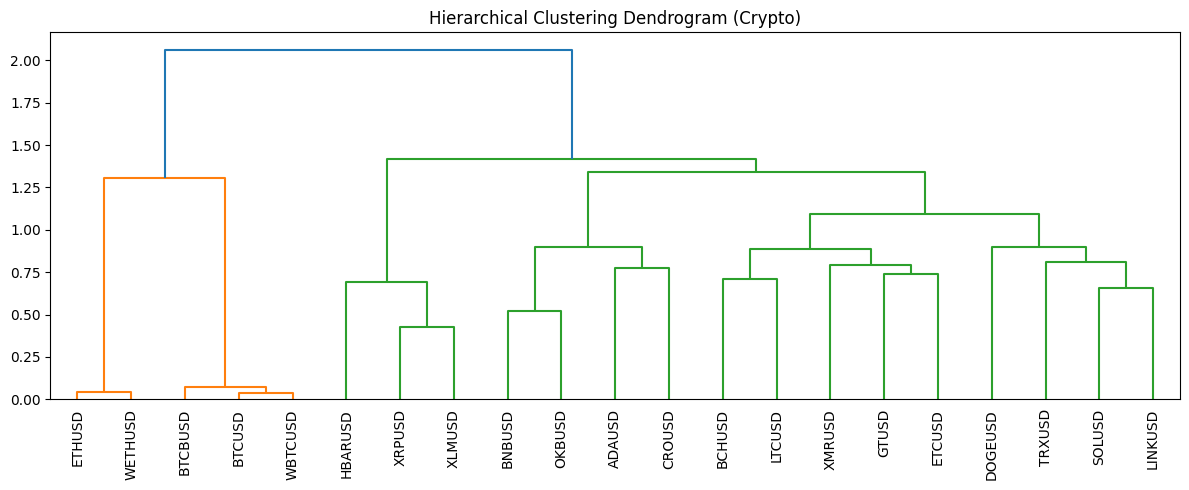

In [ ]:
# Plot dendrogram
plt.figure(figsize=(12, 5))
sch.dendrogram(link, labels=dist.columns.tolist(), leaf_rotation=90)
plt.title("Hierarchical Clustering Dendrogram (Crypto)")
plt.tight_layout()
plt.show()


### Step 7: Run HRP Optimization on All Assets (No Momentum Filter)

- We now construct the portfolio using the full monthly return matrix.
- The `HCPortfolio` object from `riskfolio-lib` handles the HRP process.
- Parameters:
  - `model='HRP'`: Use Hierarchical Risk Parity
  - `codependence='pearson'`: Correlation method for clustering
  - `rm='MV'`: Risk measure is variance
  - `linkage='ward'`: Ward method used to build the dendrogram
- The result is a risk-balanced allocation across all assets based on historical covariance.


In [ ]:
# Create portfolio object
port = rp.HCPortfolio(returns=df_monthly_returns)
# Estimate optimal portfolio:

model='HRP' # Could be HRP or HERC
codependence = 'pearson' # Correlation matrix used to group assets in clusters
rm = 'MV' # Risk measure used, this time will be variance
rf = 0 # Risk free rate
linkage = 'ward' # Linkage method used to build clusters
max_k = 10 # Max number of clusters used in two difference gap statistic, only for HERC model
leaf_order = True # Consider optimal order of leafs in dendrogram

w = port.optimization(model=model,
                      codependence=codependence,
                      rm=rm,
                      rf=rf,
                      linkage=linkage,
                      max_k=max_k,
                      leaf_order=leaf_order)

display(w.T)

,BTCUSD,ETHUSD,XRPUSD,BNBUSD,SOLUSD,DOGEUSD,ADAUSD,TRXUSD,WBTCUSD,LINKUSD,...,BCHUSD,XMRUSD,LTCUSD,BTCBUSD,WETHUSD,HBARUSD,OKBUSD,GTUSD,ETCUSD,CROUSD
weights,10.3199%,3.1768%,1.8802%,1.7569%,1.3348%,0.4320%,1.0889%,11.1712%,10.1585%,4.5902%,...,4.3293%,8.6804%,7.6332%,14.4959%,3.0862%,1.7728%,3.7517%,4.8049%,2.5525%,1.5423%


Plot weights on a pie chart

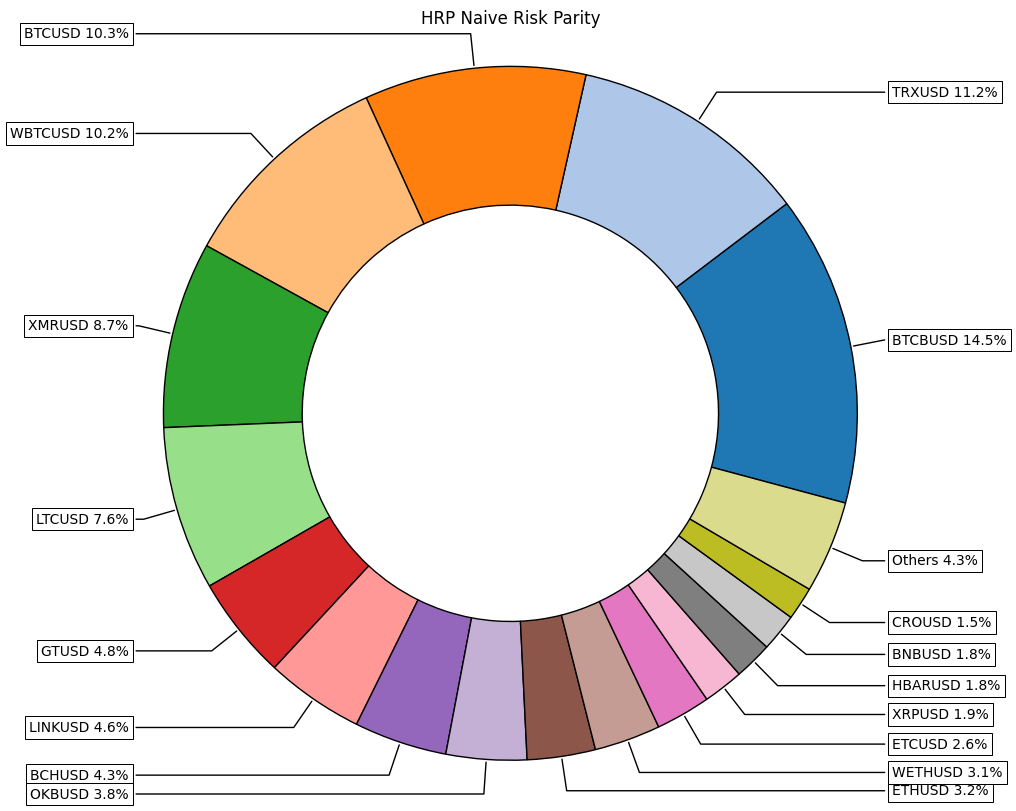

In [ ]:
# Plotting the composition of the portfolio

ax = rp.plot_pie(w=w,
                 title='HRP Naive Risk Parity',
                 others=0.05,
                 nrow=25,
                 cmap="tab20",
                 height=8,
                 width=10,
                 ax=None)

# Manually remove the legend
if ax.get_legend():
    ax.get_legend().remove()


### Step 8: Visualize Risk Contribution per Asset

- This chart shows how much risk each asset contributes to the total portfolio.
- HRP aims to **balance risk**, not capital — assets should contribute more equally to total portfolio variance.
- In a perfect risk parity portfolio, all bars would be of similar height.
- Deviations from equal contribution may occur if:
  - The asset is highly volatile or correlated with others
  - The cluster it belongs to receives a smaller share of risk
- This plot helps verify whether HRP achieved its goal of diversifying risk effectively.


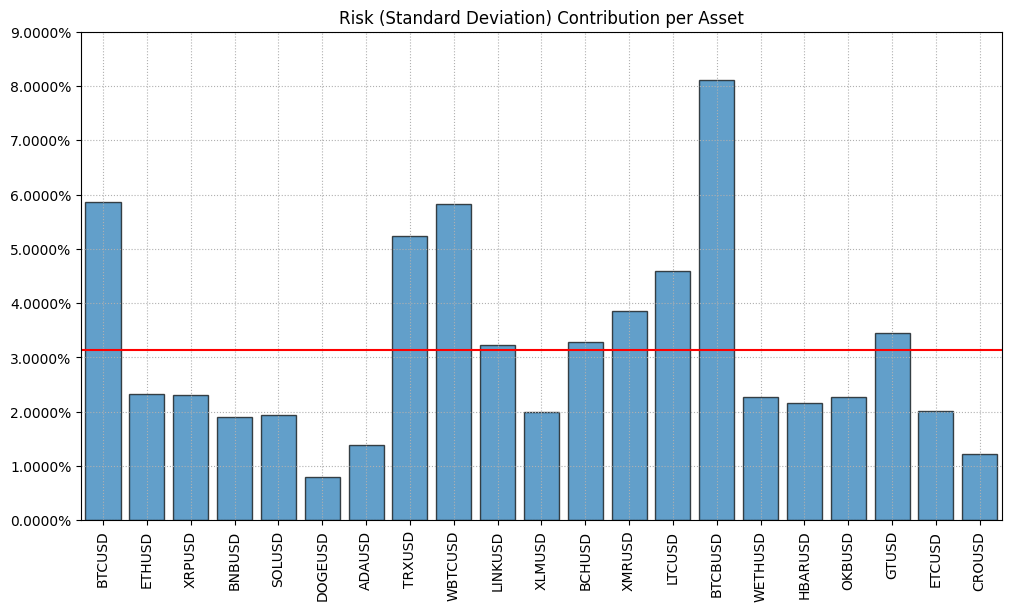

In [ ]:
# Use monthly returns (already resampled)
returns = df_monthly_returns.copy()

# Compute inputs for risk contribution plot
mu = returns.mean()
cov = returns.cov()

# Plotting risk contribution per asset
ax = rp.plot_risk_con(w=w,
                      cov=cov,
                      returns=returns,
                      rm=rm,           # e.g., 'MV', 'CVaR', etc.
                      rf=0,            # risk-free rate
                      alpha=0.05,      # for CVaR/EVaR
                      color="tab:blue",
                      height=6,
                      width=10,
                      t_factor=12,     # Monthly data (12 periods per year)
                      ax=None)


### Step 9: Compare HRP Portfolios Across Different Risk Measures

- HRP can be applied using different definitions of "risk".
- This loop runs the optimization multiple times, each with a different risk measure:
  - Volatility-based (e.g., `vol`, `MV`, `MAD`)
  - Tail risk (e.g., `CVaR`, `EVaR`, `WR`)
  - Drawdown metrics (e.g., `MDD`, `CDaR`, `UCI`)
- This allows us to compare how asset weights change depending on how risk is defined.
- The resulting DataFrame `w_s` contains all weight sets, one per risk measure.


In [ ]:
# Risk Measures available:
#
# 'vol': Standard Deviation.
# 'MV': Variance.
# 'MAD': Mean Absolute Deviation.
# 'GMD': Gini Mean Difference.
# 'MSV': Semi Standard Deviation.
# 'FLPM': First Lower Partial Moment (Omega Ratio).
# 'SLPM': Second Lower Partial Moment (Sortino Ratio).
# 'VaR': Conditional Value at Risk.
# 'CVaR': Conditional Value at Risk.
# 'TG': Tail Gini.
# 'EVaR': Entropic Value at Risk.
# 'WR': Worst Realization (Minimax).
# 'RG': Range of returns.
# 'CVRG': CVaR Range of returns.
# 'TGRG': Tail Gini Range of returns.
# 'MDD': Maximum Drawdown of uncompounded cumulative returns (Calmar Ratio).
# 'ADD': Average Drawdown of uncompounded cumulative returns.
# 'DaR': Drawdown at Risk of uncompounded cumulative returns.
# 'CDaR': Conditional Drawdown at Risk of uncompounded cumulative returns.
# 'EDaR': Entropic Drawdown at Risk of uncompounded cumulative returns.
# 'UCI': Ulcer Index of uncompounded cumulative returns.
# 'MDD_Rel': Maximum Drawdown of compounded cumulative returns (Calmar Ratio).
# 'ADD_Rel': Average Drawdown of compounded cumulative returns.
# 'DaR_Rel': Drawdown at Risk of compounded cumulative returns.
# 'CDaR_Rel': Conditional Drawdown at Risk of compounded cumulative returns.
# 'EDaR_Rel': Entropic Drawdown at Risk of compounded cumulative returns.
# 'UCI_Rel': Ulcer Index of compounded cumulative returns.

rms = ['vol', 'MV', 'MAD', 'GMD', 'MSV', 'FLPM', 'SLPM', 'VaR',
       'CVaR', 'TG', 'EVaR', 'WR', 'RG', 'CVRG', 'TGRG', 'MDD',
       'ADD', 'DaR', 'CDaR', 'EDaR', 'UCI', 'MDD_Rel',
       'ADD_Rel', 'DaR_Rel', 'CDaR_Rel', 'EDaR_Rel', 'UCI_Rel']

w_s = pd.DataFrame([])

for i in rms:
    w = port.optimization(model=model,
                          codependence=codependence,
                          rm=i,
                          rf=rf,
                          linkage=linkage,
                          max_k=max_k,
                          leaf_order=leaf_order)

    w_s = pd.concat([w_s, w], axis=1)

w_s.columns = rms

In [ ]:
w_s.style.format("{:.2%}").background_gradient(cmap='YlGn')

,vol,MV,MAD,GMD,MSV,FLPM,SLPM,VaR,CVaR,TG,EVaR,WR,RG,CVRG,TGRG,MDD,ADD,DaR,CDaR,EDaR,UCI,MDD_Rel,ADD_Rel,DaR_Rel,CDaR_Rel,EDaR_Rel,UCI_Rel
BTCUSD,8.97%,10.32%,8.19%,8.35%,7.55%,7.18%,6.77%,8.09%,5.89%,5.43%,5.29%,5.06%,9.95%,9.52%,9.71%,6.17%,6.38%,5.08%,5.71%,6.00%,5.95%,6.31%,6.94%,5.88%,6.18%,6.25%,6.59%
ETHUSD,3.72%,3.18%,3.26%,3.38%,3.28%,3.09%,3.06%,3.35%,2.90%,2.84%,2.88%,2.85%,4.22%,4.27%,4.27%,2.77%,2.78%,2.62%,2.85%,2.82%,2.87%,3.08%,3.01%,2.92%,3.04%,3.09%,3.03%
XRPUSD,3.69%,1.88%,4.07%,4.02%,4.44%,4.13%,4.68%,5.36%,5.22%,4.98%,4.75%,4.65%,3.98%,3.11%,3.46%,5.97%,4.53%,4.81%,5.30%,5.64%,4.88%,5.71%,4.01%,5.33%,5.57%,5.65%,4.56%
BNBUSD,3.63%,1.76%,5.35%,5.23%,5.81%,7.05%,6.92%,6.95%,6.69%,6.40%,6.20%,5.89%,1.80%,3.54%,2.78%,6.92%,6.52%,7.63%,6.97%,6.99%,6.65%,6.39%,5.74%,5.78%,5.82%,6.14%,5.86%
SOLUSD,3.17%,1.33%,3.07%,3.14%,3.39%,3.98%,4.13%,3.87%,4.37%,4.67%,5.00%,5.28%,4.76%,3.40%,3.90%,3.08%,3.42%,3.29%,3.09%,3.07%,3.24%,4.56%,5.07%,4.82%,4.71%,4.62%,4.81%
DOGEUSD,1.77%,0.43%,2.62%,2.68%,3.22%,4.25%,5.13%,4.82%,6.19%,6.71%,7.23%,7.90%,1.90%,1.61%,1.62%,4.68%,3.18%,3.47%,4.02%,4.37%,3.66%,5.54%,3.99%,5.02%,5.39%,5.47%,4.40%
ADAUSD,2.02%,1.09%,2.14%,2.22%,2.51%,2.40%,3.00%,3.14%,3.90%,3.97%,3.90%,3.93%,1.50%,1.78%,1.69%,1.68%,1.39%,1.73%,1.68%,1.69%,1.49%,2.39%,1.60%,2.14%,2.17%,2.29%,1.78%
TRXUSD,9.17%,11.17%,9.18%,9.04%,8.75%,10.39%,8.62%,7.39%,7.50%,7.27%,7.24%,7.10%,8.73%,9.14%,9.05%,11.56%,9.65%,9.13%,10.22%,11.02%,9.41%,7.37%,8.93%,8.09%,7.60%,7.46%,8.13%
WBTCUSD,8.90%,10.16%,8.11%,8.27%,7.51%,7.14%,6.73%,8.12%,5.85%,5.38%,5.26%,5.00%,9.85%,9.50%,9.67%,6.18%,6.39%,5.07%,5.72%,6.01%,5.97%,6.31%,6.92%,5.86%,6.18%,6.25%,6.57%
LINKUSD,6.33%,4.59%,5.83%,5.95%,5.78%,4.75%,4.99%,5.10%,5.24%,5.51%,5.81%,6.22%,7.32%,6.58%,6.71%,4.53%,3.11%,3.29%,3.95%,4.31%,3.28%,5.55%,4.06%,5.00%,5.35%,5.48%,4.47%


### Step 10: Evaluate Performance of Each Risk-Based Portfolio

- This function calculates return, volatility, Sharpe, Sortino, and max drawdown.
- It applies each set of weights from the risk measure comparison.
- Results are sorted by Sharpe ratio for easy comparison.


In [ ]:
def evaluate_risk_measure_portfolios(returns, weight_df, rf=0, freq=12):
    """
    Evaluate performance of portfolios optimized using different risk measures.

    Parameters
    ----------
    returns : pd.DataFrame
        Monthly return matrix.
    weight_df : pd.DataFrame
        Columns = risk measures, Rows = weights (indexed by asset).
    rf : float
        Annualized risk-free rate.
    freq : int
        Frequency of returns (12 for monthly, 252 for daily).

    Returns
    -------
    pd.DataFrame
        Performance metrics per risk measure.
    """
    results = []

    for rm in weight_df.columns:
        w = weight_df[rm].dropna()
        port_ret = (returns[w.index] * w).sum(axis=1)

        cum_returns = (1 + port_ret).cumprod()
        running_max = cum_returns.cummax()
        drawdown = cum_returns / running_max - 1
        max_dd = drawdown.min()

        ann_ret = (1 + port_ret).prod()**(freq / len(port_ret)) - 1
        ann_vol = port_ret.std() * np.sqrt(freq)

        downside_std = port_ret[port_ret < 0].std() * np.sqrt(freq)
        sortino = (ann_ret - rf) / downside_std if downside_std > 0 else np.nan
        sharpe = (ann_ret - rf) / ann_vol if ann_vol > 0 else np.nan

        results.append({
            'Risk Measure': rm,
            'Annual Return': ann_ret,
            'Annual Volatility': ann_vol,
            'Sharpe Ratio': sharpe,
            'Sortino Ratio': sortino,
            'Max Drawdown': max_dd
        })

    return pd.DataFrame(results).set_index('Risk Measure').sort_values('Sharpe Ratio', ascending=False)


In [ ]:
perf_table = evaluate_risk_measure_portfolios(df_monthly_returns, w_s, rf=0.02)

# Nicely formatted view
display(perf_table.style.format({
    'Annual Return': '{:.2%}',
    'Annual Volatility': '{:.2%}',
    'Sharpe Ratio': '{:.2f}'
}).highlight_max(axis=0, color='lightgreen'))


,Annual Return,Annual Volatility,Sharpe Ratio,Sortino Ratio,Max Drawdown
Risk Measure,,,,,
ADD_Rel,116.23%,86.62%,1.32,4.712515,-0.615974
ADD,111.52%,83.63%,1.31,4.263663,-0.594826
UCI,112.43%,85.36%,1.29,4.292318,-0.597978
DaR,114.26%,87.15%,1.29,4.406276,-0.594811
UCI_Rel,115.87%,88.51%,1.29,4.664782,-0.625762
CDaR,112.04%,86.94%,1.27,4.521312,-0.607925
EDaR,112.13%,87.36%,1.26,4.462376,-0.614358
MDD,112.48%,87.93%,1.26,4.434236,-0.618693
FLPM,111.06%,86.95%,1.25,4.494498,-0.652708


### Step 11: Evaluate Individual Asset Performance

- Computes the same performance metrics as before, but for each coin separately.
- Useful for comparing the optimized portfolios to individual asset performance.


In [ ]:
def evaluate_individual_assets(returns, rf=0, freq=12):
    """
    Evaluate return, volatility, Sharpe, Sortino, and Max Drawdown for each asset.

    Parameters
    ----------
    returns : pd.DataFrame
        Monthly returns with columns = tickers.
    rf : float
        Annualized risk-free rate.
    freq : int
        Frequency of returns (12 for monthly).

    Returns
    -------
    pd.DataFrame
        Performance stats per asset.
    """
    results = []

    for asset in returns.columns:
        r = returns[asset].dropna()

        cum_returns = (1 + r).cumprod()
        running_max = cum_returns.cummax()
        drawdown = cum_returns / running_max - 1
        max_dd = drawdown.min()

        ann_ret = (1 + r).prod() ** (freq / len(r)) - 1
        ann_vol = r.std() * np.sqrt(freq)

        downside_std = r[r < 0].std() * np.sqrt(freq)
        sortino = (ann_ret - rf) / downside_std if downside_std > 0 else np.nan
        sharpe = (ann_ret - rf) / ann_vol if ann_vol > 0 else np.nan

        results.append({
            'Asset': asset,
            'Annual Return': ann_ret,
            'Annual Volatility': ann_vol,
            'Sharpe Ratio': sharpe,
            'Sortino Ratio': sortino,
            'Max Drawdown': max_dd
        })

    return pd.DataFrame(results).set_index('Asset').sort_values('Sharpe Ratio', ascending=False)


In [ ]:
coin_perf_table = evaluate_individual_assets(df_monthly_returns, rf=0.02)

# Nicely formatted view
display(
    coin_perf_table.style.format({
        'Annual Return': '{:.2%}',
        'Annual Volatility': '{:.2%}',
        'Sharpe Ratio': '{:.2f}',
        'Sortino Ratio': '{:.2f}',
        'Max Drawdown': '{:.2%}'
    }).highlight_max(axis=0, color='lightgreen')
)


,Annual Return,Annual Volatility,Sharpe Ratio,Sortino Ratio,Max Drawdown
Asset,,,,,
GTUSD,112.85%,106.44%,1.04,4.04,-55.79%
TRXUSD,75.98%,73.44%,1.01,2.15,-58.89%
BTCBUSD,63.78%,65.02%,0.95,1.88,-73.01%
BTCUSD,64.09%,65.61%,0.95,1.92,-73.05%
WBTCUSD,63.66%,66.12%,0.93,1.88,-73.13%
SOLUSD,195.41%,212.46%,0.91,3.82,-95.22%
ETHUSD,63.45%,86.84%,0.71,1.66,-76.91%
WETHUSD,63.30%,88.10%,0.70,1.63,-76.89%
XMRUSD,44.82%,69.67%,0.61,1.13,-73.23%


## Momentum-Enhanced HRP Strategy

Traditional portfolio optimizations often rely on historical average returns as estimates for future performance. However, in highly volatile and regime-driven markets like crypto, this approach can be unreliable.

Instead of using historical means, we adopt a simple and time-tested signal: **6-month momentum**.

- Momentum has been widely documented to outperform naïve mean-based return forecasts.
- At each rebalance, we only include assets that have delivered a **positive total return over the past 6 months**.
- This directional filter allows the HRP model to allocate risk more efficiently by focusing on assets with recent strength.


### Step 1: Define Semi-Annual Rebalance Dates

- We rebalance the portfolio every 6 months, at the end of June and December.
- This reflects a realistic, low-turnover approach suitable for longer-horizon strategies.
- Rebalancing dates are extracted from the monthly return index to ensure alignment with available data.


In [ ]:
# Use your monthly returns DataFrame
monthly_returns = df_monthly_returns.copy()

# Make sure index is datetime and sorted
df_monthly_returns.index = pd.to_datetime(df_monthly_returns.index)
df_monthly_returns = df_monthly_returns.sort_index()

# Filter index for June 30 and December 31 only
rebalance_dates = df_monthly_returns.index[
    ((df_monthly_returns.index.month == 6) & (df_monthly_returns.index.day == 30)) |
    ((df_monthly_returns.index.month == 12) & (df_monthly_returns.index.day == 31))
]

# Sanity check
print("Valid rebalance dates:")
print(rebalance_dates)


Valid rebalance dates:
DatetimeIndex(['2020-06-30', '2020-12-31', '2021-06-30', '2021-12-31',
               '2022-06-30', '2022-12-31', '2023-06-30', '2023-12-31',
               '2024-06-30', '2024-12-31'],
              dtype='datetime64[ns]', name='date', freq=None)


### Step 2: Define 6-Month Momentum Calculation

- This function calculates each asset's total return over the **6 months leading up to** the rebalance date.
- We use geometric chaining of monthly returns:  
  \[(1 + r_1) × (1 + r_2) × ... × (1 + r_6) - 1\]
- Only assets with **positive momentum** will be considered for HRP optimization.
- This ensures that capital is only allocated to assets showing recent strength.


In [ ]:
def calculate_6m_momentum_from_returns(returns, rebalance_date):
    """
    Calculate geometric 6-month momentum using monthly return data
    ending the month *before* the rebalance date.

    Parameters
    ----------
    returns : pd.DataFrame
        Monthly return matrix (index = date, columns = tickers).
    rebalance_date : datetime
        Rebalance point (momentum is calculated from 6 months prior).

    Returns
    -------
    pd.Series
        6-month momentum per asset.
    """
    try:
        end_loc = returns.index.get_loc(rebalance_date)
    except KeyError:
        return None

    start_loc = end_loc - 6
    if start_loc < 0:
        return None

    window = returns.iloc[start_loc:end_loc]  # excludes rebalance_date

    if len(window) < 6:
        return None

    momentum = (1 + window).prod() - 1
    return momentum


### Step 3: Calculate and Review Momentum Scores at Each Rebalance Date

- For each semi-annual rebalance date, we compute 6-month momentum for all assets.
- The results are stored in a dictionary and sorted from highest to lowest momentum.
- This allows us to visually inspect which assets would qualify for inclusion in the portfolio at each point in time.


In [ ]:
# Store momentum vectors by date
momentum_by_date = {}

for date in rebalance_dates[1:]:  # skip the first (2020-06-30) – it has no lookback
    momentum = calculate_6m_momentum_from_returns(df_monthly_returns, date)
    if momentum is not None:
        momentum_by_date[date] = momentum.sort_values(ascending=False)

# Show summary
for date, mom in momentum_by_date.items():
    print(f"\n=== Momentum as of {date.date()} ===")
    print(mom.round(4).to_string())




=== Momentum as of 2020-12-31 ===
LINKUSD   245.3400%
SOLUSD    245.0600%
XRPUSD    227.4100%
XLMUSD    188.3500%
ETHUSD    166.4800%
WETHUSD   166.0500%
ADAUSD    130.4000%
WBTCUSD   109.0400%
BTCUSD    108.6900%
BTCBUSD   108.1300%
TRXUSD    104.0700%
XMRUSD     99.6900%
LTCUSD     92.3600%
BNBUSD     85.7300%
DOGEUSD    38.9800%
BCHUSD     33.1300%
OKBUSD      6.4400%
GTUSD      -0.8300%
ETCUSD     -1.4000%
CROUSD    -17.5500%
HBARUSD   -21.2500%

=== Momentum as of 2021-06-30 ===
DOGEUSD   9075.1600%
SOLUSD    1568.4300%
BNBUSD    1027.8200%
ETCUSD     922.8100%
ADAUSD     915.1800%
GTUSD      855.1500%
HBARUSD    580.7200%
WETHUSD    340.3000%
ETHUSD     338.7600%
OKBUSD     148.3400%
TRXUSD     136.9100%
LINKUSD    125.1400%
BCHUSD     121.2500%
LTCUSD     114.5200%
XMRUSD     109.3600%
XLMUSD      98.3000%
WBTCUSD     89.8300%
BTCBUSD     89.1900%
BTCUSD      89.1000%
CROUSD      78.8500%
XRPUSD      57.5400%

=== Momentum as of 2021-12-31 ===
SOLUSD    535.8900%
CROUSD    448.

### Step 4: Run Momentum-Filtered HRP Strategy

- This loop implements the full strategy:
  - At each June/December rebalance date, compute 6-month momentum.
  - Only include assets with positive momentum.
  - Use past 6 months of returns to compute the covariance matrix.
  - If fewer than 4 valid assets → equal weight.
  - If 0 assets → assign 0% return for the next 6 months.
  - Otherwise, run HRP optimization.
- The selected weights are applied to the next 6 months of returns.
- Final output is a complete stream of monthly portfolio returns.


In [ ]:
from collections import defaultdict

# --- Parameters ---
rf = 0
model = 'HRP'
codependence = 'pearson'
linkage = 'ward'
leaf_order = True
holding_period = 6
freq = 12

# --- Storage ---
port_ret_series = []
weight_records = []
dates_used = []

# --- Loop through rebalancing periods ---
for i in range(1, len(rebalance_dates) - 1):
    rebalance_date = rebalance_dates[i]
    next_date = rebalance_dates[i + 1]

    # --- Step 1: Calculate 6-month momentum ---
    mu = calculate_6m_momentum_from_returns(df_monthly_returns, rebalance_date)
    if mu is None:
        print(f"{rebalance_date.date()}: Skipped — no valid momentum.")
        continue

    mu = mu[mu > 0]
    if mu.empty:
        print(f"{rebalance_date.date()}: No positive momentum — assign 0% returns for next 6 months.")

        # Fill 0% return for next 6 months
        start = df_monthly_returns.index.get_loc(rebalance_date) + 1
        end = df_monthly_returns.index.get_loc(next_date) + 1
        zero_returns = pd.Series(0, index=df_monthly_returns.index[start:end])

        port_ret_series.append(zero_returns)
        weight_records.append(pd.DataFrame([], columns=["weights"]))
        dates_used.append(rebalance_date)
        continue

    # --- Step 2: Covariance from same window ---
    end_idx = df_monthly_returns.index.get_loc(rebalance_date)
    start_idx = end_idx - 6
    window_returns = df_monthly_returns.iloc[start_idx:end_idx]
    cov = window_returns.cov()

    # --- Step 3: Align assets ---
    valid_assets = mu.index.intersection(cov.columns)
    mu = mu.loc[valid_assets]
    cov = cov.loc[valid_assets, valid_assets]
    window_returns = window_returns[valid_assets]

    if len(valid_assets) == 0:
        print(f"{rebalance_date.date()}: Skipped — no valid intersection.")
        continue

    # --- Step 4: Handle fallback cases ---
    if len(valid_assets) < 4:
        print(f"{rebalance_date.date()}: Using equal weights for {len(valid_assets)} assets.")
        weights = pd.DataFrame(1 / len(valid_assets), index=valid_assets, columns=["weights"])
    else:
        # Full HRP optimization
        port = rp.HCPortfolio()
        port.mu = mu
        port.cov = cov
        port.returns = window_returns

        try:
            weights = port.optimization(
                model=model,
                codependence=codependence,
                rm='MV',
                rf=rf,
                linkage=linkage,
                max_k=10,
                leaf_order=leaf_order
            )
        except Exception as e:
            print(f"{rebalance_date.date()}: Optimization failed — {e}")
            continue

    weights = weights[weights > 0]  # clean zero weights
    weight_records.append(weights)
    dates_used.append(rebalance_date)

    # --- Step 5: Apply weights to next 6 months ---
    try:
        start = df_monthly_returns.index.get_loc(rebalance_date) + 1
        end = df_monthly_returns.index.get_loc(next_date) + 1
        holding_returns = df_monthly_returns.iloc[start:end]

        port_ret = (holding_returns[weights.index] * weights.squeeze()).sum(axis=1)
        port_ret_series.append(port_ret)
    except Exception as e:
        print(f"{rebalance_date.date()}: Return application failed — {e}")
        continue

# --- Step 6: Combine into one return stream ---
combined_returns = pd.concat(port_ret_series).sort_index()


2022-06-30: No positive momentum — assign 0% returns for next 6 months.


In [ ]:
combined_returns

,0
date,
2021-01-31,27.5751%
2021-02-28,124.0675%
2021-03-31,28.2085%
2021-04-30,70.1717%
2021-05-31,-33.5435%
2021-06-30,-16.5305%
2021-07-31,10.4557%
2021-08-31,25.3660%
2021-09-30,-9.9804%


### Step 5: Compare Cumulative Performance to BTC

- This chart shows the growth of $1 for:
  - The momentum-enhanced HRP strategy
  - A simple buy-and-hold position in BTC
- It allows visual comparison of overall performance and drawdowns over time.


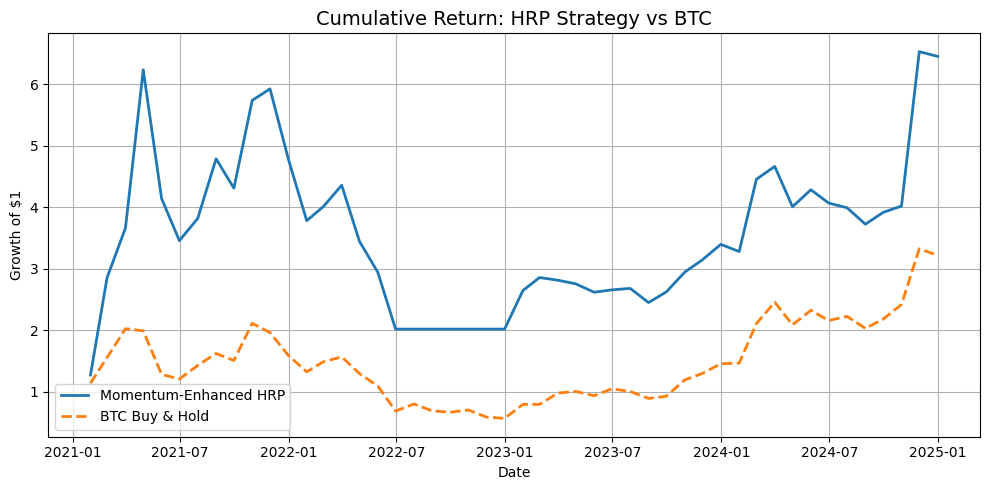

In [ ]:
import matplotlib.pyplot as plt

# Compute cumulative growth
cumulative = (1 + combined_returns).cumprod()

btc_returns = df_monthly_returns['BTCUSD'].loc[combined_returns.index]
btc_cumulative = (1 + btc_returns).cumprod()

plt.figure(figsize=(10, 5))
plt.plot(cumulative, label="Momentum-Enhanced HRP", linewidth=2)
plt.plot(btc_cumulative, label="BTC Buy & Hold", linestyle="--", linewidth=2)
plt.title("Cumulative Return: HRP Strategy vs BTC", fontsize=14)
plt.xlabel("Date")
plt.ylabel("Growth of $1")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()



### Step 6: Evaluate Final Strategy Performance vs Benchmarks

- This block calculates and compares key performance metrics for:
  - The momentum-enhanced HRP strategy
  - A buy-and-hold BTC benchmark
  - An equal-weighted portfolio rebalanced every 6 months
- Metrics include:
  - Annualized return and volatility
  - Sharpe and Sortino ratios
  - Maximum drawdown
- This summary helps assess whether the momentum overlay improves the risk-reward profile of HRP.


In [ ]:
def summarize_performance(returns, rf=0.02, freq=12):
    ann_return = (1 + returns).prod()**(freq / len(returns)) - 1
    ann_vol = returns.std() * np.sqrt(freq)
    downside = returns[returns < 0].std() * np.sqrt(freq)
    sharpe = (ann_return - rf) / ann_vol if ann_vol > 0 else np.nan
    sortino = (ann_return - rf) / downside if downside > 0 else np.nan
    cum_returns = (1 + returns).cumprod()
    max_dd = (cum_returns / cum_returns.cummax() - 1).min()

    return {
        'Annual Return': ann_return,
        'Annual Volatility': ann_vol,
        'Sharpe Ratio': sharpe,
        'Sortino Ratio': sortino,
        'Max Drawdown': max_dd
    }

# Calculate metrics
hrp_perf = summarize_performance(combined_returns)
btc_perf = summarize_performance(btc_returns)

equal_weight_returns = []

for i in range(1, len(rebalance_dates) - 1):
    rebalance_date = rebalance_dates[i]
    next_date = rebalance_dates[i + 1]

    # Assets with valid returns at rebalance date
    available_assets = df_monthly_returns.columns[df_monthly_returns.loc[rebalance_date].notna()]
    if len(available_assets) == 0:
        continue

    w_eq = pd.Series(1 / len(available_assets), index=available_assets)

    # Apply to next 6 months of returns
    try:
        holding_period_returns = df_monthly_returns.loc[rebalance_date:next_date]
        port_ret = (holding_period_returns[w_eq.index] * w_eq).sum(axis=1)
        equal_weight_returns.append(port_ret)
    except:
        continue

# Combine to full stream
equal_weight_combined = pd.concat(equal_weight_returns).sort_index()
equal_perf = summarize_performance(equal_weight_combined)

# Combine all
perf_df = pd.DataFrame(
    [hrp_perf, btc_perf, equal_perf],
    index=['Momentum-Enhanced HRP', 'BTC Buy & Hold', 'Equal Weight']
)

# Show formatted
display(perf_df.style.format({
    'Annual Return': '{:.2%}',
    'Annual Volatility': '{:.2%}',
    'Sharpe Ratio': '{:.2f}',
    'Sortino Ratio': '{:.2f}',
    'Max Drawdown': '{:.2%}'
}).highlight_max(axis=0, color='lightgreen'))



,Annual Return,Annual Volatility,Sharpe Ratio,Sortino Ratio,Max Drawdown
Momentum-Enhanced HRP,59.40%,91.43%,0.63,1.65,-67.58%
BTC Buy & Hold,33.96%,64.78%,0.49,0.96,-73.05%
Equal Weight,58.89%,97.62%,0.58,2.02,-84.90%


## Conclusion

This notebook demonstrated how to apply Hierarchical Risk Parity (HRP) to a cryptocurrency universe, and how to enhance it with a momentum overlay.

Key takeaways:

- Traditional HRP balances portfolio risk using historical correlations, but does not incorporate directional return signals.
- By filtering assets to include only those with positive 6-month momentum, we improve alignment with market trends while still benefiting from HRP’s robust risk allocation.
- The momentum-enhanced HRP strategy outperformed both BTC buy & hold and an equal-weighted portfolio on a risk-adjusted basis (Sharpe ratio), while also reducing drawdowns compared to equal weight.

This approach shows how combining time-tested strategies like momentum with modern allocation frameworks like HRP can lead to more effective portfolio construction — even in volatile markets like crypto.
